Loading and unloading the Lithosphere
======

Loading of the lithosphere can be described with an initial periodic surface displacement of an infinite fluid half space. The viscous solution to this problem, outlined in Turcotte and Schubert (1982), 6-10.  The surface decreases exponentially with time and is dependent on the magnitude, $w_m$, and wavelengthm $\lambda$ of the perturbation, and the viscosity, $\eta$ and density, $\rho$ of the fluid.

$$ w = w_m exp\Big(\frac{-\lambda g t}{4\pi\eta}\Big) $$

where $w$ is displacement, $g$ is gravity, $t$ time. This solution can be charaterised by the relaxation time, $t_m = 4\pi\eta / \rho g \lambda $, the time take for the initial load to decrease expotentially by $e^{-1}$.

The following notebook outlines this analytic solution and compairs it to a numerical solution produced using Underworld.

In [1]:
import matplotlib.pyplot as pyplot
%matplotlib inline

import numpy as np

In [2]:
# initial displacement is given by
w_m    = 0.05 # displacement magnitue, << Lambda
Lambda = 1.0  # displacement wavelength

xMax = 4
tMax = 100

x = np.linspace(0, xMax, xMax*100+1)
t = np.linspace(0, tMax, tMax*100+1)

# initial displacement
w_0 = w_m * np.cos(2.*np.pi*x/Lambda)

rho = 1.0 # density of displaced fluid
g   = 1.0 # gravity
mu  = 1e0 # viscosity of fluid (mantle)

# when load is removed
t_relax = 4*np.pi*mu/(Lambda*rho*g)
w_t     = w_m * np.exp(-1.*t/t_relax)

print t_relax

12.5663706144


/Users/rfarrington/venv_default/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


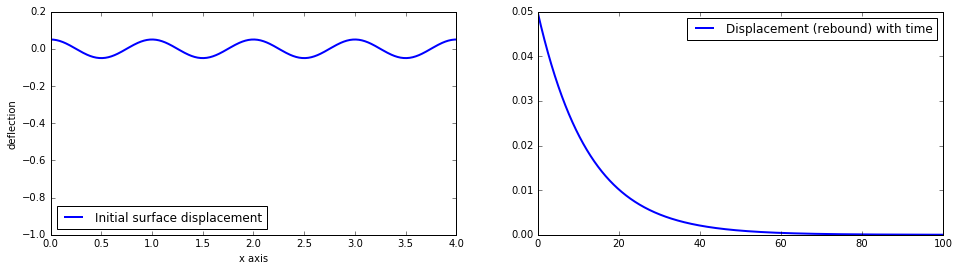

In [3]:
fig = pyplot.figure()
fig.set_size_inches(16, 4)
ax1 = fig.add_subplot(1,2,1)
ax1.plot()
ax1.plot(x, w_0, label='Initial surface displacement', lw = 2)
ax1.legend(loc='best')
ax1.axis([0, 4, -1., 0.2])
ax1.set_xlabel('x axis')
ax1.set_ylabel('deflection')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(t, w_t, label='Displacement (rebound) with time', lw = 2)
ax2.legend(loc='best')
ax2.axis([0, tMax, 0, w_m])

fig.show()

In [4]:
import underworld as uw
from underworld import function as fn
uw.matplotlib_inline()
import glucifer
import os

In [5]:
# model domain
boxLength = 4.0 # km
boxHeight = 1.2  # km   
minCoord = [-boxLength/2.,-0.8]
maxCoord = [ boxLength/2.,0.2]
aspectRatio = boxLength/boxHeight

unitRes    = 32  # try 64, 128
resolution = [int(unitRes*aspectRatio),unitRes]

# create the mesh
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = resolution, 
                                 minCoord    = minCoord, 
                                 maxCoord    = maxCoord,
                                 periodic    = [True, False], 
                               ) 

# create & initialise the field variables
velocityField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

In [6]:
# Construct node sets using the mesh specialSets
topWall    = mesh.specialSets["MaxJ_VertexSet"]
bottomWall = mesh.specialSets["MaxJ_VertexSet"]

# periodic side walls, no slip top wall, supporting bottom wall
dirichletBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                               indexSetsPerDof = ( topWall, topWall) ) 

neumannBC = uw.conditions.NeumannCondition( fn_flux        = ( 0.0, 1.0), 
                                           variable        = velocityField,
                                           indexSetsPerDof = ( None, bottomWall) )


In [7]:
# Create a swarm.
swarm          = uw.swarm.Swarm( mesh=mesh, particleEscape=True )

# Create a layout object, populate the swarm with particles.
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

# Create material variables
materialIndex          = swarm.add_variable( dataType="int", count=1 )
previousStress         = swarm.add_variable( dataType="double", count=3 )
previousStress.data[:] = [0., 0., 0.]

# population control if needed
population_control = uw.swarm.PopulationControl(swarm, 
                                                aggressive=True,
                                                splitThreshold=0.15, 
                                                maxDeletions=2,
                                                maxSplits=10,
                                                particlesPerCell=20)

In [8]:
# trace the surface deformation
tracerSwarm    = uw.swarm.Swarm( mesh=mesh )
tracerSwarmRes = 201
particleCoordinatesMid  = np.zeros((tracerSwarmRes,2))
particleCoordinatesMid[:,0] = np.linspace(minCoord[0], maxCoord[0], tracerSwarmRes)
particleCoordinatesMid[:,1] = w_m * np.cos(2.*np.pi*particleCoordinatesMid[:,0]/Lambda)
temp = tracerSwarm.add_particles_with_coordinates(particleCoordinatesMid)

# trace rebound with time
tracerSwarm2    = uw.swarm.Swarm( mesh=mesh )
tracerSwarmRes = 1
tracerSwarm2.add_particles_with_coordinates(np.array([(0.,w_m)]))

array([0], dtype=int32)

In [9]:
# layout material types
materialAir           = 0
materialMantle        = 3

for index in range( len(swarm.particleCoordinates.data) ):
    coord = swarm.particleCoordinates.data[index][:]
    w_0 = w_m * np.cos(2.*np.pi*coord[0]/Lambda)
    if coord[1] < w_0:
        materialIndex.data[index] = materialMantle
    else:
        materialIndex.data[index] = materialAir


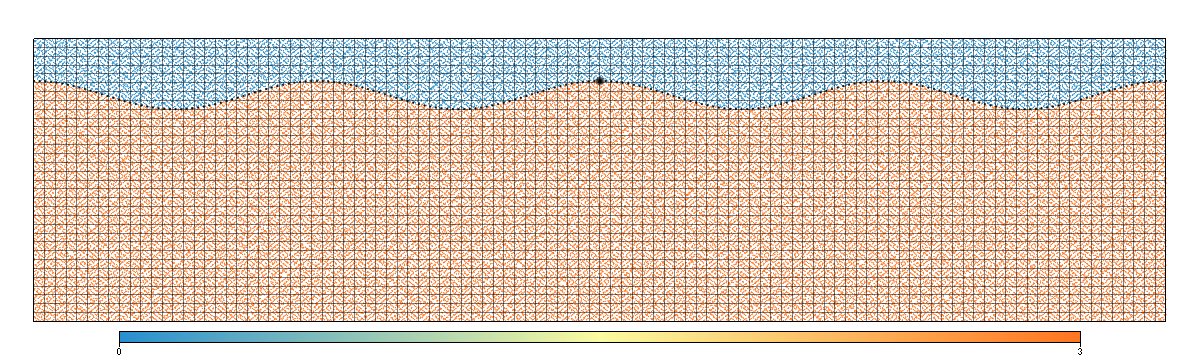

In [10]:
# plot material type and passive tracer swarms
figsize=(boxLength*300,boxHeight*300)
figMaterial = glucifer.Figure( figsize=figsize )
figMaterial.append( glucifer.objects.Mesh(mesh,opacity=0.5))
figMaterial.append( glucifer.objects.Points(tracerSwarm2, pointSize=10, colourBar=False) )
figMaterial.append( glucifer.objects.Points(tracerSwarm, pointSize=3, colourBar=False) )
figMaterial.append( glucifer.objects.Points(swarm, materialIndex, pointSize=2) )
figMaterial.show()

In [11]:
# Set a density of '0.' for light material, '1.' for dense material.
densityMap   = {  materialAir  : 0.0,
                materialMantle : rho,
                }
densityFn    = fn.branching.map( fn_key = materialIndex, mapping = densityMap )

In [12]:
# Set a viscosity for materials.
viscosityMap = {  materialAir  : 1.0e-3,
                materialMantle : mu,
                }    
fn_viscosity  = fn.branching.map( fn_key = materialIndex, mapping = viscosityMap )

In [13]:
# Define a vertical unit vector using a python tuple.
z_hat = ( 0.0, 1.0 )

# Create buoyancy force vector
buoyancyFn = -densityFn*g*z_hat

In [14]:
# define strain rate tensor
strainRate = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariant = fn.tensor.second_invariant(strainRate)

In [15]:
# create stokes system, solver and advectors
stokes = uw.systems.Stokes( velocityField = velocityField, 
                            pressureField = pressureField,
                            voronoi_swarm = swarm, 
                            conditions    = [dirichletBC, neumannBC],
                            fn_viscosity  = fn_viscosity, 
                            fn_bodyforce  = buoyancyFn,
)
    
solver = uw.systems.Solver( stokes )
solver.set_inner_method("mumps")
# Optional solver settings
if(uw.nProcs()==1):
    solver.set_inner_method("lu")

# Create a system to advect the swarm
advector        = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )
advectorTracer  = uw.systems.SwarmAdvector( swarm=tracerSwarm, velocityField=velocityField, order=2 )
advectorTracer2 = uw.systems.SwarmAdvector( swarm=tracerSwarm2, velocityField=velocityField, order=2 )

In [16]:
# define an update function
def update():
    # Retrieve the maximum possible timestep for the advection system.
    dt = advector.get_max_dt() 
    if dt > t_relax/100.:  # set this to t_relax/100 for best fit 
        dt = t_relax/100.  
        
    # Advect using this timestep size.
    advector.integrate(dt)
    advectorTracer.integrate(dt)
    advectorTracer2.integrate(dt)
    
    population_control.repopulate() 
    
    return time+dt, step+1, dt

In [17]:
# Initialise time and timestep.
time = 0.
step = 0
dt   = 0

tTracer      = []
displacement = []

In [18]:
# time stepping loop
while time < 40:
    # Get instantaneous Stokes solution
    solver.solve()

    tTracer.append(time)
    displacement.append(tracerSwarm2.particleCoordinates.data[0][1])
    if step % 20 == 0:
        print step, time, displacement[step]

    # We are finished with current timestep, update.
    time, step, dt = update()

0 0.0 0.05
20 2.51327412287 0.0410419809344
40 5.02654824574 0.0335545782773
60 7.53982236862 0.0274129425279
80 10.0530964915 0.0223979662299
100 12.5663706144 0.0183239752733
120 15.0796447372 0.0151107922826
140 17.5929188601 0.0123597154967
160 20.106192983 0.00965945067839
180 22.6194671058 0.00777469400725
200 25.1327412287 0.00627078886296
220 27.6460153516 0.00499570182511
240 30.1592894745 0.00391405367573
260 32.6725635973 0.00315641636157
280 35.1858377202 0.00259857558546
300 37.6991118431 0.00224298813217



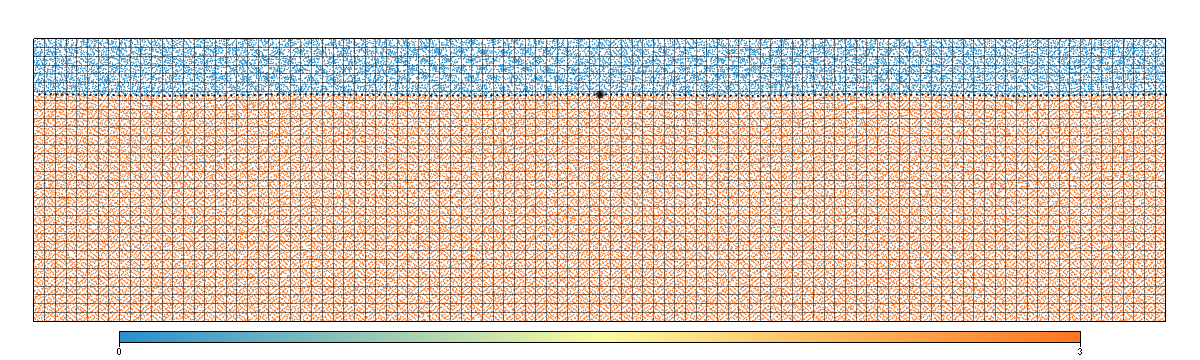

In [19]:
figMaterial.append( glucifer.objects.VectorArrows( mesh, velocityField))
figMaterial.show()

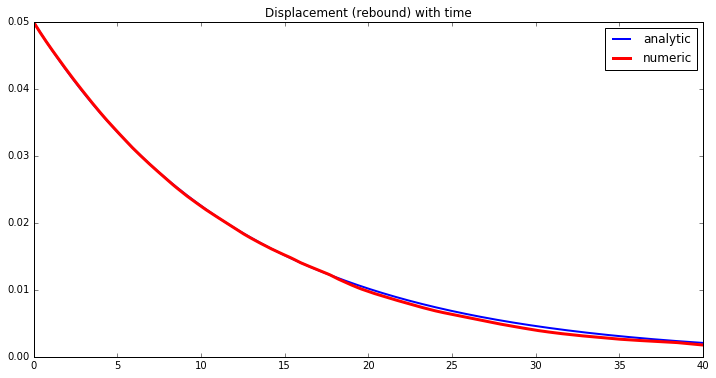

In [22]:
# plot tracer particles displacement with time
fig = pyplot.figure()
fig.set_size_inches(12, 6)
ax = fig.add_subplot(1,1,1)
    
ax.plot(t, w_t, label='analytic', lw = 2)
ax.plot(tTracer, displacement, lw=3, label='numeric', c='red')#, marker='.')
ax.legend(loc='best')
ax.axis([0, 40, 0, w_m])
ax.set_title('Displacement (rebound) with time')
# ax.axhline(0.,color='black',linestyle='--',)
# ax.axvline(t_relax,color='black',linestyle='--')

fig.show()